# Model Selection and Weight Decay

### Polynomial Regression

$$y = 5 + 1.2x - 3.4\frac{x^2}{2!} + 5.6 \frac{x^3}{3!}$$

We first import the libraries:

In [1]:
%matplotlib inline
import ml_utils
from mxnet import autograd, gluon, nd
from mxnet.gluon import data as gdata, loss as gloss, nn

### Dataset Generation

$$y = 5 + 1.2x - 3.4\frac{x^2}{2!} + 5.6 \frac{x^3}{3!} + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0,0.1)$$

Model weights:

In [2]:
# maximum degree of the polynomial
maxdegree = 20      
# allocate lots of empty space
true_w = nd.zeros(maxdegree)  
true_w[0:4] = nd.array([5, 1.2, -3.4, 5.6])

In [3]:
# training and validation data set sizes
n_train, n_test = 100, 1000

features = nd.random.normal(shape=(n_train + n_test, 1))
features = nd.random.shuffle(features)

poly_features = nd.power(features, nd.arange(maxdegree).reshape((1,-1)))
poly_features = poly_features / (nd.gamma(nd.arange(maxdegree)+1).reshape((1,-1)))
labels = nd.dot(poly_features, true_w)
labels += nd.random.normal(scale=0.1, shape=labels.shape)

Split into training and validation set:

In [4]:
train_features = poly_features[:n_train, :]
test_features = poly_features[n_train:, :]
train_labels = labels[:n_train]
test_labels = labels[n_train:]

### Network Definition

In [5]:
def get_net():
    net = nn.Sequential()
    # Switch off the bias, since
    # we already catered for it in the features
    net.add(nn.Dense(1, use_bias=False))
    net.initialize()
    return net

loss = gloss.L2Loss()

### Training Loop

In [6]:
def fit(train_iter, net, loss, batch_size, trainer):
    for X, y in train_iter:
        with autograd.record():
            l = loss(net(X), y)
        l.backward()
        trainer.step(batch_size)

### Defining, Training and Testing Model

In [7]:
def train_and_test(train_features, test_features, train_labels, test_labels, wd=0):
    net = get_net()
    trainer = gluon.Trainer(net.collect_params(), 'sgd',
                            {'learning_rate': 0.1, 'wd': wd})
    batch_size = min(10, train_labels.shape[0])
    dataset = gdata.ArrayDataset(train_features, train_labels)
    train_iter = gdata.DataLoader(dataset, batch_size, shuffle=True)
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        fit(train_iter, net, loss, batch_size, trainer)
        evaluate = lambda X, y: loss(net(X), y).mean().asscalar()
        train_ls.append(evaluate(train_features, train_labels))
        test_ls.append(evaluate(test_features, test_labels))
    return train_ls, test_ls

### Third-order Polynomial Function Fitting

Pick the first four dimensions, i.e. 1, x, x^2, x^3 from the polynomial features

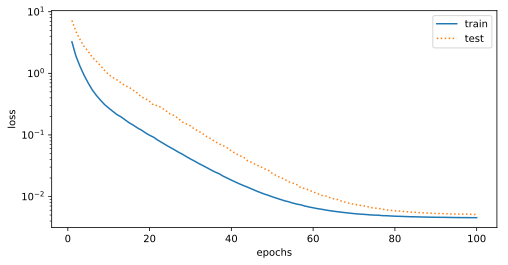

In [8]:
num_epochs = 100
train_ls, test_ls = train_and_test(train_features[:, 0:4], test_features[:, 0:4],
                                   train_labels, test_labels)

ml_utils.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
                  range(1, num_epochs + 1), test_ls, ['train', 'test'])

### Linear Function Fitting

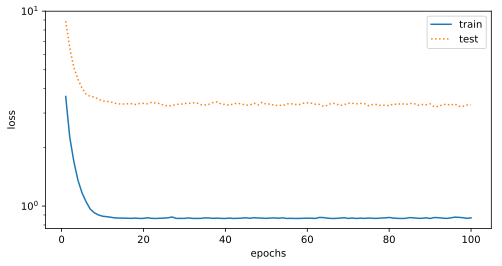

In [9]:
# Pick the first two dimensions, i.e. 1, x from the polynomial features
train_ls, test_ls = train_and_test(train_features[:, 0:3], test_features[:, 0:3],
                                   train_labels, test_labels)
ml_utils.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
                  range(1, num_epochs + 1), test_ls, ['train', 'test'])

### Overfitting

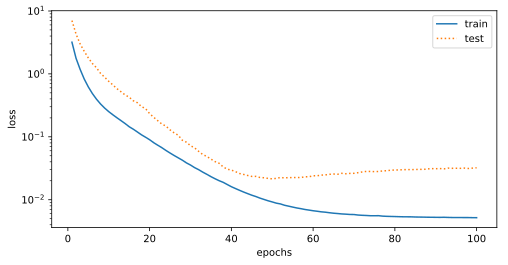

In [10]:
n_degree = 20   # degree of polynomials
train_ls, test_ls = train_and_test(train_features[:, 0:n_degree], test_features[:, 0:n_degree],
                                   train_labels, test_labels, wd=0)
ml_utils.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
                  range(1, num_epochs + 1), test_ls, ['train', 'test'])